### **1 - Loading & Splitting Data Step**

In [1]:
###Importing Used Libriries

## guaranteeing that the magic library has its dependencies to be installed 
!apt-get update
!apt-get install -y libmagic1
!pip install python-magic ## identifies file types by checking their headers according to a predefined list of file types

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import magic
import re
import gc ## clear memory (for Kaggle save & run all)

## to deal with model training
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

# Find out if using GPU
gpu = !nvidia-smi -L
print(gpu[0].split(' (')[0] if gpu[0].startswith('GPU') else 'Not using GPU')


# Setting the random seed for reproducibility
seed = 42
np.random.seed(seed) ## for numpy
tf.random.set_seed(seed) ## for tf
random.seed(seed) ## for random module on python

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1562 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:6 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]   
Get:7 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]       
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1208 kB]
Get:10 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [22.5 kB]
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease              
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/univ

2024-05-28 21:32:55.221109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 21:32:55.221239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 21:32:55.341449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU 0: Tesla P100-PCIE-16GB


#### 1.1

In [2]:
# Loading Data
main_path = '/kaggle/input/animals10/raw-img'

## translating labels
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca":"cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

## collecting paths and images' info
df_all = pd.DataFrame()
for dirname, _, filenames in os.walk(main_path):
    paths = [dirname + '/' + filename for filename in filenames]
    folder_name = os.path.split(dirname)[-1]
    df_all = pd.concat([df_all, pd.DataFrame({'path': paths, 'class': folder_name})], ignore_index=True)

## transforms to df
df_all = pd.DataFrame(df_all)

## selecting only jpeg images
extensions = df_all['path'].apply(lambda s: s.split('.')[-1])
df_all = df_all[extensions == 'jpeg']

## convert class labels to English
df_all['class'] = df_all['class'].map(translate)

df_all.head()

path  class
0  /kaggle/input/animals10/raw-img/cavallo/OIP-md...  horse
1  /kaggle/input/animals10/raw-img/cavallo/OIP-TP...  horse
2  /kaggle/input/animals10/raw-img/cavallo/OIP-jl...  horse
3  /kaggle/input/animals10/raw-img/cavallo/OIP-F4...  horse
4  /kaggle/input/animals10/raw-img/cavallo/OIP-UF...  horse

#### Now we have only *.jpeg images with the English label correctly associated.

#### 1.2

In [3]:
%%time
# Filtering the dataset to the desired size (to be less computationally expensive)

## function that finds width and height of a given image path
def find_img_res(row):
  ## load info
  t = magic.from_file(row["path"])
  ## select img size
  matches = re.findall('(\d+)x(\d+)', t)
  ## 1st is density 2nd is resolution
  width, height = matches[1]
  return int(width), int(height)

df_all[['width', 'height']] = df_all.apply(find_img_res, axis=1, result_type="expand")

## define classes and the number of classes
classes = list(df_all['class'].unique())
n_classes = len(classes)

## printing info
print('--- classes ---')
print(f'Classes = {classes}')
print(f'Nº classes = {n_classes}')

df_all

--- classes ---
Classes = ['horse', 'sheep', 'elephant', 'cat', 'squirrel', 'chicken', 'spider', 'cow', 'dog', 'butterfly']
Nº classes = 10
CPU times: user 7.83 s, sys: 2.63 s, total: 10.5 s
Wall time: 2min 57s


path      class  width  \
0      /kaggle/input/animals10/raw-img/cavallo/OIP-md...      horse    225   
1      /kaggle/input/animals10/raw-img/cavallo/OIP-TP...      horse    200   
2      /kaggle/input/animals10/raw-img/cavallo/OIP-jl...      horse    300   
3      /kaggle/input/animals10/raw-img/cavallo/OIP-F4...      horse    300   
4      /kaggle/input/animals10/raw-img/cavallo/OIP-UF...      horse    300   
...                                                  ...        ...    ...   
26172  /kaggle/input/animals10/raw-img/farfalla/OIP-x...  butterfly    250   
26173  /kaggle/input/animals10/raw-img/farfalla/OIP-w...  butterfly    300   
26174  /kaggle/input/animals10/raw-img/farfalla/OIP-4...  butterfly    300   
26175  /kaggle/input/animals10/raw-img/farfalla/OIP-Q...  butterfly    300   
26176  /kaggle/input/animals10/raw-img/farfalla/OIP-1...  butterfly    300   

       height  
0         300  
1         300  
2         197  
3         169  
4         225  
...       ...  
26172     250  
26173     280  
26174     225  
26175     271  
26176     300  

[24209 rows x 4 columns]

#### The dataset has 10 classes with the labels shown above.

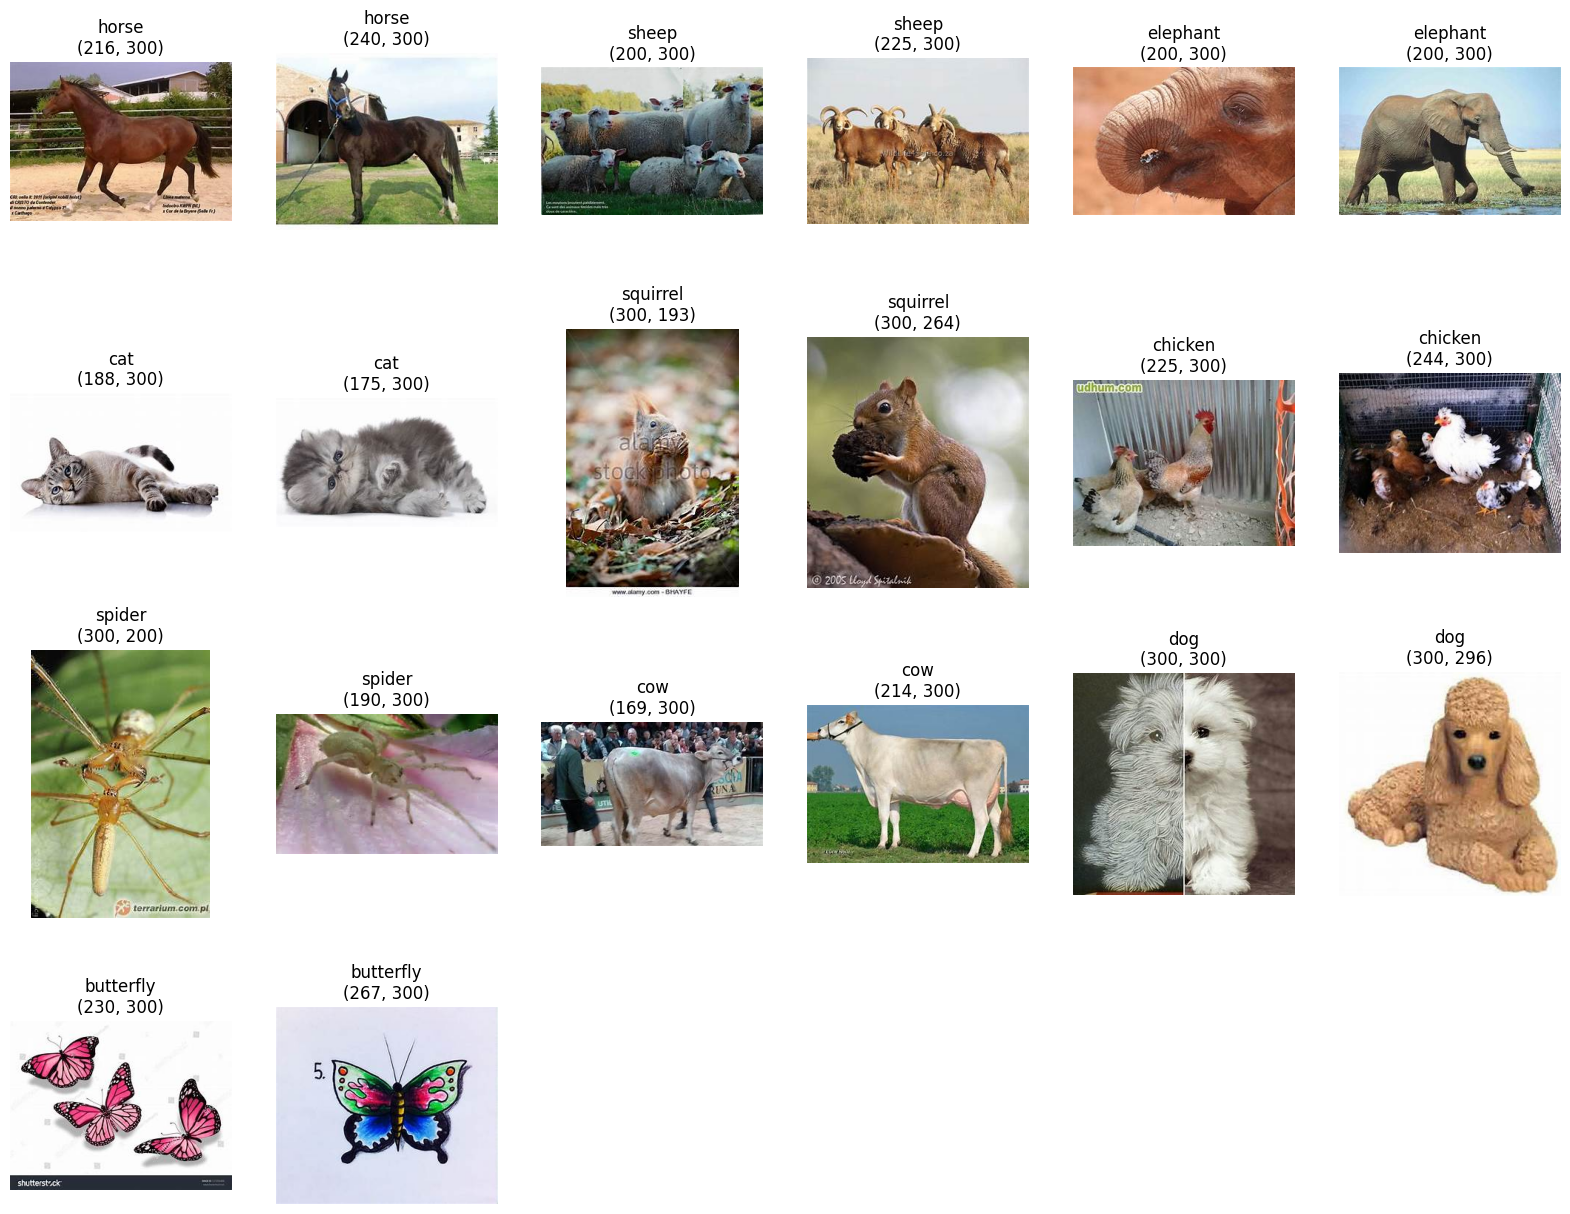

In [4]:
# Showing some samples of the dataset

plt.figure(figsize=(20, 16))
for i, label in enumerate(classes):
  subset = df_all['path'][df_all['class'] == label].sample(2, random_state=42)
  for j in range(2):
    plt.subplot(4, 6, 2*i+j+1)
    img = plt.imread(subset.iloc[j])
    plt.imshow(img)
    plt.title(f'{label}\n{img.shape[:2]}')
    plt.axis('off')

In [5]:
# Filtering and Reducing the Size of the Dataset
# Selecting only images with a width and height greater than or equal to 225 and only 150 images per class

## function that reduces the number of samples per class
def reduce_instances_per_class(df, col_name, num_instances_per_class, print_info=False):
  ## creates temporary datasets that helps to reduce to the desired size
  df_temp = []
  variables = df[col_name].unique()
  variables.sort()
  for class_ in variables:
    ## selects portion of the dataset of the desired class
    temp = df[df[col_name] == class_].sample(n=num_instances_per_class,
                                          random_state=42)

    ## saves to concatenate at the end
    df_temp.append(temp)

  ## concatenates all sub-datasets in the dataset with desired size
  small = pd.concat(df_temp, axis=0)

  ## confirms the correct division by class
  if print_info:
    print('-'*30)
    print('Nº instances in relation to the name column')
    print(small[col_name].value_counts())
    print('-'*30)

  return small

In [6]:
#Filters minimum size images
size = 225
df = df_all[(df_all['width'] >= size) & (df_all['height'] >= size)]

## limit the number per class
df = reduce_instances_per_class(df=df,
                                    col_name='class',
                                    num_instances_per_class=150)
# prints
display(df['class'].value_counts())
df

class
butterfly    150
cat          150
chicken      150
cow          150
dog          150
elephant     150
horse        150
sheep        150
spider       150
squirrel     150
Name: count, dtype: int64

path      class  width  \
25024  /kaggle/input/animals10/raw-img/farfalla/OIP-7...  butterfly    300   
24226  /kaggle/input/animals10/raw-img/farfalla/OIP-d...  butterfly    258   
25272  /kaggle/input/animals10/raw-img/farfalla/OIP-F...  butterfly    300   
24227  /kaggle/input/animals10/raw-img/farfalla/OIP-3...  butterfly    300   
26143  /kaggle/input/animals10/raw-img/farfalla/OIP-H...  butterfly    300   
...                                                  ...        ...    ...   
8658   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   squirrel    300   
9138   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   squirrel    300   
7836   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   squirrel    300   
7772   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   squirrel    300   
7705   /kaggle/input/animals10/raw-img/scoiattolo/OIP...   squirrel    300   

       height  
25024     225  
24226     300  
25272     300  
24227     240  
26143     271  
...       ...  
8658      225  
9138      225  
7836      257  
7772      225  
7705      225  

[1500 rows x 4 columns]

#### The dataset has now only 150 images per class, containing images with width and height greater or equal to 225 pixels, totaling 1500 images.

#### 1.3

In [7]:
# Splitting Data into Training, Validation and Test sets

## function that creates the subsets of a give df containing the path of the files
def create_dataset(dataframe, img_size, batch_size):
    paths = dataframe['path']
    labels = dataframe['class'].map(classes.index) # ordinal encoder
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
## parameters examples
random_state=42
img_size=(100,100) ## standardizing image dimensions, also helps the training to be faster
batch_size=25

## separates between training (full and reduced), validation and testing, always with a uniform number of images per class
df_train_val, df_test = train_test_split(df, test_size=25*n_classes, stratify=df['class'], random_state=random_state)
df_train, df_val = train_test_split(df_train_val, test_size=25*n_classes, stratify=df_train_val['class'], random_state=random_state)
df_train_small, _ = train_test_split(df_train, train_size=25*n_classes, stratify=df_train['class'], random_state=random_state)

## creates the datasets
ds_train_small = create_dataset(df_train_small, img_size, batch_size)
ds_train = create_dataset(df_train, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)
ds_test = create_dataset(df_test, img_size, batch_size)

## see datasets infos
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Nº train (small) = {len(df_train_small)}')
print(f'Nº train (full)  = {len(df_train)}')
print(f'Nº val           = {len(df_val)}')
print(f'Nº test          = {len(df_test)}')

------------------------------
datasets division
------------------------------
Nº train (small) = 250
Nº train (full)  = 1000
Nº val           = 250
Nº test          = 250


#### Train (small) counts only with 25 images per class, totaling 250 samples, the train (full) has 1000 samples due to removing 25 images per class for the validation and test sets.

### **2 - Main Development**

#### 2.1 (a)

In [9]:
# Chosing an Architecture from https://keras.io/api/applications/

## ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

## defining a function that creates the used model
def create_resnet50V2_model(input_shape, num_classes=10):
    ## removes last layer used on ImageNet dataset classification task
    resnet50V2_model = ResNet50V2(include_top = False, input_shape = input_shape, pooling = 'avg')

    ## unfreezing the network weights
    resnet50V2_model.trainable = True

    ## adapting the model to different input size
    i = Input(shape=input_shape)
    x = preprocess_input(i)
    x = resnet50V2_model(x, training=False) ## ensures that the batch statistics estimated by the BatchNormalization layer during original model training are not changed
    x = Dense(10, activation='softmax')(x) ## new last layer to fits the task of the presented dataset
    resnet50V2_model = Model(inputs=i, outputs=x)
    
    return resnet50V2_model

## defines function to do the training step using callbacks
def train(model, epochs, lr, callbacks, ds_train, ds_val, batch_size):
  from tqdm.keras import TqdmCallback
  callbacks = callbacks + [TqdmCallback(verbose=0)]
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
  history = model.fit(ds_train, validation_data=ds_val, verbose=0, callbacks=callbacks, epochs=epochs, batch_size=batch_size)
  return history

In [10]:
%%time
# Choosing initial hyperparameters to construct the baseline model
epochs = 25
lr = 0.001  # Low learning rate

## adjusting model to the dataset/task
input_shape = img_size + (3,) ## (80,80,3)

base_model = create_resnet50V2_model(input_shape, num_classes = 10)
base_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

CPU times: user 1.89 s, sys: 332 ms, total: 2.23 s
Wall time: 6.92 s


In [11]:
%%time

##compiling and training
base_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
base_model.fit(ds_train_small, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

del base_model ## deletes model to free up memory
del ds_train_small
tf.keras.backend.clear_session()
gc.collect() ## forces garbage collection to free up memory


Epoch 1/25
 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1300 - loss: 2.8338 

I0000 00:00:1716932254.473896     636 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716932254.548926     636 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.1976 - loss: 2.5829 - val_accuracy: 0.1520 - val_loss: 11.7222
Epoch 2/25
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4800 - loss: 1.6143

W0000 00:00:1716932258.650386     638 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6134 - loss: 1.4024 - val_accuracy: 0.1280 - val_loss: 8.7129
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8824 - loss: 0.4093 - val_accuracy: 0.1000 - val_loss: 15.4877
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9827 - loss: 0.0844 - val_accuracy: 0.1480 - val_loss: 7.1181
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9945 - loss: 0.0266 - val_accuracy: 0.1480 - val_loss: 5.5133
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9973 - loss: 0.0208 - val_accuracy: 0.1400 - val_loss: 6.5275
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9890 - loss: 0.0181 - val_accuracy: 0.1320 - val_loss: 7.8996
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.1400 - val_loss: 9.7572
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.1720 - val_loss: 9

0

#### The model is overfitting on the training set, due to its high accuracy on training but low on validation.

#### 2.1 (b)

In [12]:
## Defining function for plotting the loss and accuracy curves
def plots(history, xlim=None, ylim=None, net_name=str):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.title(f"{net_name} \nVal accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 455ms/step - accuracy: 0.1169 - loss: 2.4627 - val_accuracy: 0.3360 - val_loss: 2.2698
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9023 - loss: 0.9016 - val_accuracy: 0.4600 - val_loss: 1.7273
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.1487 - val_accuracy: 0.4560 - val_loss: 1.6893
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0247 - val_accuracy: 0.4280 - val_loss: 1.6612
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.4120 - val_loss: 1.6635
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.4040 - val_loss: 1.6737
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.4120 - val_loss: 1.6814
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.4120 -

0

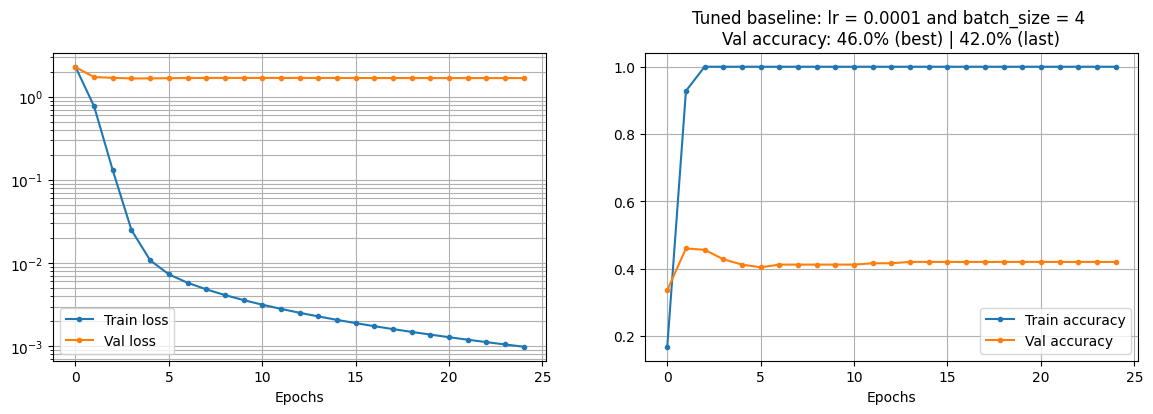

In [13]:
%%time
# Optimizing the Batch size and Learning Rate

## best tested lr
lr = 0.0001
## best tested batch_size
batch_size = 4

base_model = create_resnet50V2_model(input_shape, num_classes = 10)

## creates callback to reduce the learning rate when the model doesn't improve
#callbacks = [ReduceLROnPlateau(factor=0.6, patience=5, verbose=1)]
    
##regenerate the ds_train_small and ds_val due to fit the desired batch size
ds_train_small = create_dataset(df_train_small, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)

##compiling and training
base_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
history = base_model.fit(ds_train_small, validation_data=ds_val, epochs=epochs, batch_size=batch_size)


plots(history, net_name=f'Tuned baseline: lr = {lr} and batch_size = {batch_size}')

del base_model ## deletes model to free up memory
tf.keras.backend.clear_session()
gc.collect() ## forces garbage collection to free up memory

#### **Previous tests:**

* #### Varying the learning rate hyperparameter we perceive that the more we increase it, the less accurate the model gets, but also, as expected, if the value is too small, 25 epochs seems not enough for the model to converge. We tested the values 0.00001, 0.0001, 0.001, 0.005, and 0.01. Among them, the value of 0.0001 seems to achieve the best result, with a good trade-off between accuracy and the number of epochs to converge.

* ##### Link for the graphs of learning rate tests: https://drive.google.com/drive/folders/1yA_slHxszbk9llsdOncDedld97gYuaOt?usp=sharing

* #### For the batch size, we perceive that it makes the accuracy on the validation set vary a lot depending on the value we set: a small value made a good result but increasing it just gave a much worse accuracy. Generarly, the greater the batch_size, the lower is this variation, because more samples make the step less "drunky-like", but it also increase the training time. We tested the values 4, 16, 32, 64 and 80. Among them, batches with 64 samples seems to give the best result.

* ##### Link for the graphs of batch size tests: https://drive.google.com/drive/folders/1ejrrA8JPjhi9yU6T7sHN1tRn7x-XAC51?usp=sharing

* #### Combining the hyperparameters that gave the highest values for the val accuracy (not just the 1st, the 2nd and 3rd too), we got the best result using the lr = 0.0001 and the batch_size with 4 samples.

#### 2.2

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 333ms/step - accuracy: 0.1497 - loss: 5.1674 - val_accuracy: 0.2840 - val_loss: 10.2698
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8475 - loss: 0.4455 - val_accuracy: 0.2960 - val_loss: 8.2426
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9538 - loss: 0.1999 - val_accuracy: 0.3040 - val_loss: 7.1797
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9845 - loss: 0.0753 - val_accuracy: 0.3000 - val_loss: 6.7410
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 7.5364e-04 - val_accuracy: 0.3040 - val_loss: 6.3982
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 3.2424e-04 - val_accuracy: 0.2720 - val_loss: 6.2475
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 2.4200e-04 - val_accuracy: 0.2800 - val_loss: 6.1808
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 1.9493e-04 - val_a

0

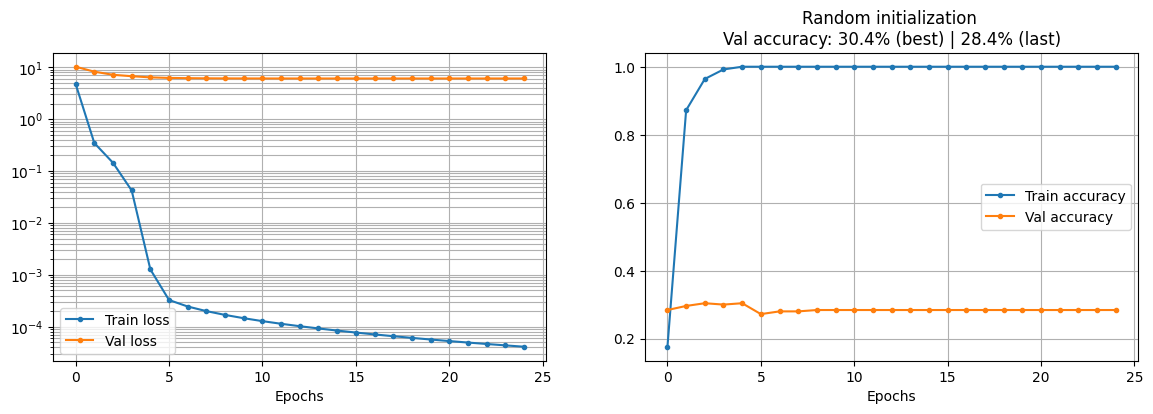

In [23]:
# Testing now with randomized weights instead of the weights from ImageNet
from tensorflow.keras.initializers import RandomNormal

## creating function that initialize the weights randomly
def initialize_weights_randomly(model):
    initializer = RandomNormal(mean=0.0, stddev=0.2, seed=9)
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and layer.trainable:
            layer.kernel.initializer = initializer
            if hasattr(layer, 'kernel'):
                layer.kernel.assign(initializer(layer.kernel.shape, layer.kernel.dtype))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias_initializer = initializer
                layer.bias.assign(initializer(layer.bias.shape, layer.bias.dtype))

                
base_model_rand_init = create_resnet50V2_model(input_shape, num_classes=10)               

## initializing random weights
initialize_weights_randomly(base_model_rand_init)

base_model_rand_init.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
history_base_model_rand_init = base_model_rand_init.fit(ds_train_small, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

plots(history_base_model_rand_init, net_name='Random initialization')


del base_model_rand_init ## deletes model to free up memory
tf.keras.backend.clear_session()
gc.collect() ## forces garbage collection to free up memory

#### We got a much worse result (about 10% lower for the best result) using the weights initialized randomly in comparison to using loaded weights from the training on the ImageNet dataset. This can tell that using transfer learning and fine-tuning indeed helps to achieve better results.

#### 2.3

In [14]:
# Testing Data Augmentation

## defining data augmentation pipelines
def get_data_augmentation_pipeline(augmentation_type):
    if augmentation_type == 'flip':
        return tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        ])
    elif augmentation_type == 'rotation':
        return tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.2),
        ])
    elif augmentation_type == 'contrast':
        return tf.keras.Sequential([
            tf.keras.layers.RandomContrast(0.1),
        ])
    else:
        raise ValueError("Unknown augmentation type")

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 336ms/step - accuracy: 0.1637 - loss: 2.3707 - val_accuracy: 0.2720 - val_loss: 2.5155
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5499 - loss: 1.6298 - val_accuracy: 0.3480 - val_loss: 2.2304
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6241 - loss: 1.2199 - val_accuracy: 0.4360 - val_loss: 2.1282
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7370 - loss: 0.9339 - val_accuracy: 0.4520 - val_loss: 2.0166
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8381 - loss: 0.6652 - val_accuracy: 0.4800 - val_loss: 1.9350
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9083 - loss: 0.3952 - val_accuracy: 0.5200 - val_loss: 1.9111
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9469 - loss: 0.3068 - val_accuracy: 0.5160 - val_loss: 1.9860
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9465 - loss: 0.2137 - val_accuracy: 0.5120 -

0

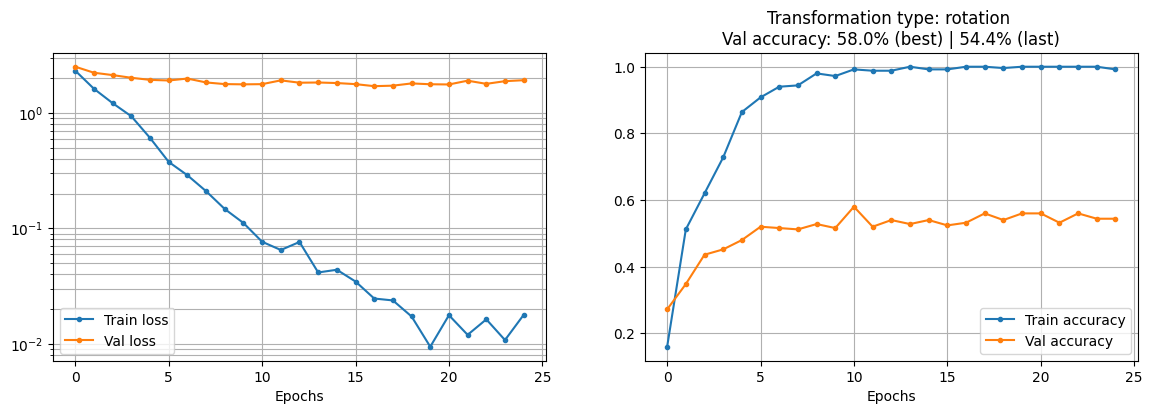

In [15]:
## list with different types of transformations
#augmentation_types = ['flip', 'rotation', 'contrast']

## setting the used augmentation transformation
aug_type = 'rotation'


## using best transformation

data_augmentation = get_data_augmentation_pipeline(aug_type)
ds_train_small_augmented = ds_train_small.map(lambda x, y: (data_augmentation(x, training=True), y))

## instantiates and trains the model
base_model = create_resnet50V2_model(input_shape=input_shape, num_classes=10)


## compile and training
base_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
history = base_model.fit(ds_train_small_augmented, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

plots(history, net_name=f'Transformation type: {aug_type}')


del base_model ## deletes model to free up memory
del ds_train_small_augmented
tf.keras.backend.clear_session()
gc.collect() ## forces garbage collection to free up memory

#### After training 3 types of transformations (flip, rotation, contrast) we can observe the validation accuracy (which is the metric that we're trying to maximize) and perceive that using augmentation helps increase it a bit but the results doesn't vary that much. For the RandomRotation transformation, we obtain the highest value, so we can conclude that this transformation is more useful to the dataset in order to reduce the overfitting and maximize our goal.

*  ##### Link for the transformations tests: https://drive.google.com/drive/folders/1ZpDmhlVkbG2Bvakj6uCf4_ZKcC8l3DIC?usp=sharing

#### 2.4 (a, b)

In [16]:
# Trying different image sizes

import time ## for tracking time of each img_size training


img_size_list = [(80,80), (100,100), (150,150), (200,200), (225,225)]


best_val_accuracy = 0
best_img_size = None
results = []

## testing different image sizes
for img_size in img_size_list:
    
    start_time = time.time() ## training time
    
    ## regenerate the ds_train_small and the ds_val due to fit the desired img size
    ds_train_small = create_dataset(df_train_small, img_size, batch_size)
    ds_val = create_dataset(df_val, img_size, batch_size)
    
    ## using the best transformation
    data_augmentation_best = get_data_augmentation_pipeline(aug_type)
    ds_train_small_augmented = ds_train_small.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    
    ## instantiates and trains the model
    input_shape = (img_size) + (3,) ## changes it to fit the new size
    
    model = create_resnet50V2_model(input_shape=input_shape, num_classes=10)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
    history = model.fit(ds_train_small_augmented, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

    
    end_time = time.time()
    training_time = end_time - start_time
    
    ## see val loss and accuracy
    val_loss, val_accuracy = (history.history['val_loss'][-1]), (history.history['val_accuracy'][-1])
    
    results.append((img_size, val_accuracy, training_time))
    print(f'Image Size: {img_size}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Training Time: {training_time:.2f} seconds')
    
    del model ## deletes model to free up memory
    del ds_train_small
    del ds_train_small_augmented
    del ds_val
    tf.keras.backend.clear_session()
    gc.collect() ## forces garbage collection to free up memory
    
    ## checks if current tested aug is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_img_size = img_size
       
print(30*'--')
print(f'Best Image Size: {best_img_size}, Best Val Accuracy: {best_val_accuracy}')


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - accuracy: 0.1196 - loss: 2.4515 - val_accuracy: 0.1040 - val_loss: 3.4836
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3548 - loss: 2.0071 - val_accuracy: 0.2120 - val_loss: 2.8634
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5084 - loss: 1.6876 - val_accuracy: 0.2760 - val_loss: 2.5441
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5693 - loss: 1.4242 - val_accuracy: 0.3240 - val_loss: 2.4039
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6930 - loss: 1.1720 - val_accuracy: 0.3520 - val_loss: 2.4489
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8130 - loss: 0.7935 - val_accuracy: 0.3640 - val_loss: 2.2405
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8429 - loss: 0.6619 - val_accuracy: 0.3840 - val_loss: 2.2745
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8797 - loss: 0.4992 - val_accuracy: 0.3880 -

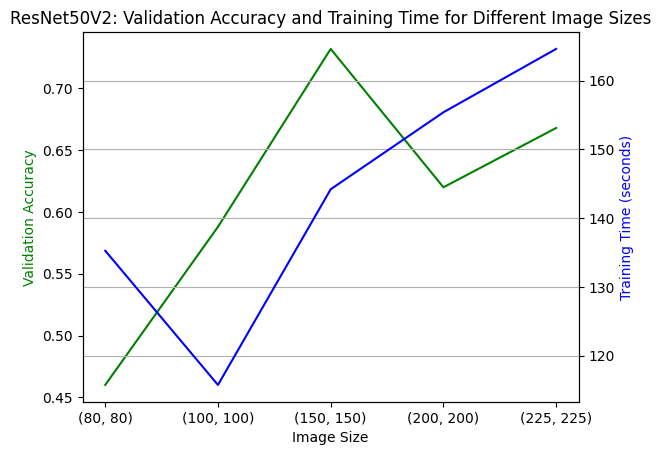

In [17]:
## Comparing training time and accuracy

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Image Size', 'Val Accuracy', 'Training Time'])


# Plotting the results
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot([str(size) for size in results_df['Image Size']], results_df['Val Accuracy'], 'g-')
ax2.plot([str(size) for size in results_df['Image Size']], results_df['Training Time'], 'b-')

ax1.set_xlabel('Image Size')
ax1.set_ylabel('Validation Accuracy', color='g')
ax2.set_ylabel('Training Time (seconds)', color='b')

plt.title('ResNet50V2: Validation Accuracy and Training Time for Different Image Sizes')
plt.grid(True)
plt.show()

#### The model performs better when we increase the image size, but it also increases the training time, so we have another trade-off. Based on the curve, looking for having both a good accuracy but not so long training time, we can choose the 200x200 resolution. This model was originally trained using 224x224 images.

#### 2.5

In [18]:
# Changing the model architecture
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input 

## InceptionResNetV2
def create_inception_resnetV2_model(input_shape, num_classes=10):
    ## removes last layer used on ImageNet dataset classification task
    incep_resnetV2_model = InceptionResNetV2(include_top = False, input_shape = input_shape, pooling = 'avg')

    ## unfreezing the network weights
    incep_resnetV2_model.trainable = True

    ## adapting the model to different input size
    i = Input(shape=input_shape)
    x = preprocess_input(i)
    x = incep_resnetV2_model(x, training=False) ## ensures that the batch statistics estimated by the BatchNormalization layer during original model training are not changed
    x = Dense(10, activation='softmax')(x) ## new last layer to fits the task of the presented dataset
    incep_resnetV2_model = Model(inputs=i, outputs=x)
    
    return incep_resnetV2_model

In [19]:
# Trying different image sizes

import time ## for tracking time of each img_size training


img_size_list = [(80,80), (100,100), (150,150), (200,200), (225,225)]


best_val_accuracy = 0
best_img_size = None
results_inception = []

## testing different image sizes
for img_size in img_size_list:
    
    start_time = time.time() ## training time
    
    ## regenerate the ds_train_small and the ds_val due to fit the desired img size
    ds_train_small = create_dataset(df_train_small, img_size, batch_size)
    ds_val = create_dataset(df_val, img_size, batch_size)
    
    ## using the best transformation
    data_augmentation_best = get_data_augmentation_pipeline(aug_type)
    ds_train_small_augmented = ds_train_small.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    
    ## instantiates and trains the model
    input_shape = (img_size) + (3,) ## changes it to fit the new size
    
    
    model = create_inception_resnetV2_model(input_shape=input_shape, num_classes=10)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
    history = model.fit(ds_train_small_augmented, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

    
    end_time = time.time()
    training_time = end_time - start_time
    
    ## see val loss and accuracy
    val_loss, val_accuracy = (history.history['val_loss'][-1]), (history.history['val_accuracy'][-1])
    
    results_inception.append((img_size, val_accuracy, training_time))
    print(f'Image Size: {img_size}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Training Time: {training_time:.2f} seconds')
    
    del model ## deletes model to free up memory
    del ds_train_small
    del ds_train_small_augmented
    del ds_val
    tf.keras.backend.clear_session()
    gc.collect() ## forces garbage collection to free up memory
    
    ## checks if current tested aug is better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_img_size = img_size
       
print(30*'--')
print(f'Best Image Size: {best_img_size}, Best Val Accuracy: {best_val_accuracy}')


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.1100 - loss: 2.5737 - val_accuracy: 0.2160 - val_loss: 2.2071
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3834 - loss: 1.9109 - val_accuracy: 0.2360 - val_loss: 2.2889
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5153 - loss: 1.5705 - val_accuracy: 0.2920 - val_loss: 3.4775
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4994 - loss: 1.4881 - val_accuracy: 0.2960 - val_loss: 105.9089
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.4889 - loss: 1.4538 - val_accuracy: 0.3200 - val_loss: 2158.3674
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5313 - loss: 1.3139 - val_accuracy: 0.3640 - val_loss: 7601.0586
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6529 - loss: 1.0338 - val_accuracy: 0.3360 - val_loss: 16539.7812
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/

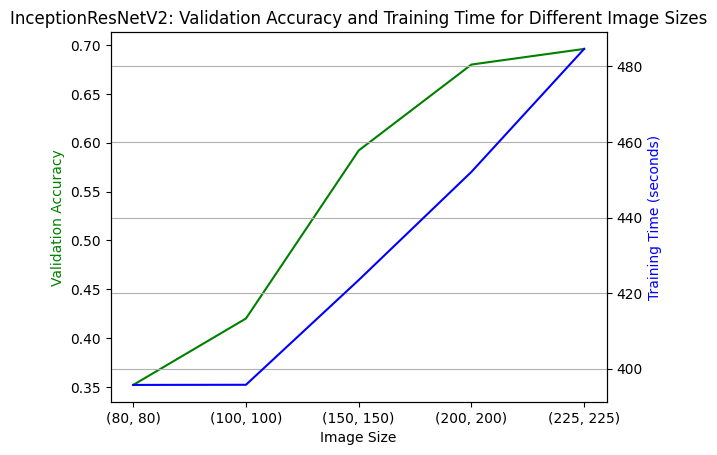

In [20]:
## Comparing training time and accuracy

# Convert results to DataFrame for better visualization
results_inception_df = pd.DataFrame(results_inception, columns=['Image Size', 'Val Accuracy', 'Training Time'])


# Plotting the results
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot([str(size) for size in results_inception_df['Image Size']], results_inception_df['Val Accuracy'], 'g-')
ax2.plot([str(size) for size in results_inception_df['Image Size']], results_inception_df['Training Time'], 'b-')

ax1.set_xlabel('Image Size')
ax1.set_ylabel('Validation Accuracy', color='g')
ax2.set_ylabel('Training Time (seconds)', color='b')

plt.title('InceptionResNetV2: Validation Accuracy and Training Time for Different Image Sizes')
plt.grid(True)
plt.show()

#### Comparing the results with the baseline architecture (ResNetV2), this graph shows that it has the same tendency (the greater the resolution of the image, the better). What it does change is that the hyperparameters are tuned for the baseline, so it's result is better than the Inception archtecture, which uses the same values (but it also shows that the results even without tunning the hyperparameters are quite similar, showing that this model is more robust). This particularlly architecture was originally trained using 299x299 images.

In [14]:
## From now on using using fixed img_size
img_size = (200,200)

input_shape = (img_size) + (3,) ## add number of channels (rgb)

## regenerate the ds_val due to fit the desired img size
ds_val = create_dataset(df_val, img_size, batch_size)

## guaranteeing using the best hyperparameters
## best tested lr
lr = 0.0001
## best tested batch_size
batch_size = 4
## epochs
epochs = 25

#### 2.6 (a, b)

In [15]:
%%time
# Testing Subsets with different Nº of images per class

n_values = [5, 10, 15, 20, 25, 50, 75, 100]

subsets = {}

## Looping over n_values to create subsets
for n in n_values:
    ## creating a new DataFrame containing n images of each class
    df_subset = pd.DataFrame()
    for label in df_train['class'].unique():
        df_label = df_train[df_train['class'] == label].iloc[:n]
        df_subset = pd.concat([df_subset, df_label])
    
    subsets[n] = df_subset

CPU times: user 83.4 ms, sys: 2.98 ms, total: 86.4 ms
Wall time: 84 ms


In [16]:
val_accuracy = []
train_accuracy = []
    
## Looping over created subsets to train models
for n, df_subset in subsets.items():
    ## creates the dataset of the subset
    ds_train_reduced = create_dataset(df_subset, img_size, batch_size)
    
    print(f'\n Training using subset with {n} images per class.\n')
    model = create_resnet50V2_model(input_shape=input_shape, num_classes=10)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
    
    history = model.fit(ds_train_reduced, validation_data=ds_val, epochs=epochs, batch_size=batch_size, verbose=0)
    
    train_accuracy.append(history.history['accuracy'][-1])
    val_accuracy.append(history.history['val_accuracy'][-1])
    
    del model ## deletes model to free up memory
    del ds_train_reduced
    tf.keras.backend.clear_session()
    gc.collect() ## forces garbage collection to free up memory


 Training using subset with 5 images per class.


 Training using subset with 10 images per class.


 Training using subset with 15 images per class.


 Training using subset with 20 images per class.


 Training using subset with 25 images per class.


 Training using subset with 50 images per class.


 Training using subset with 75 images per class.


 Training using subset with 100 images per class.



#### 2.6 (c)

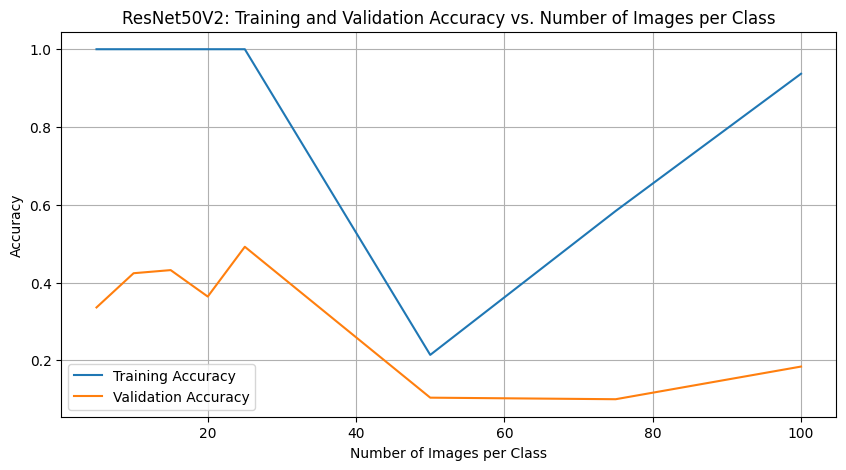

In [17]:
# Plotting a training curve with accuracies as a function of the size of the training dataset

plt.figure(figsize=(10, 5))
plt.plot(n_values, train_accuracy, label='Training Accuracy')
plt.plot(n_values, val_accuracy, label='Validation Accuracy')
plt.xlabel('Number of Images per Class')
plt.ylabel('Accuracy')
plt.title('ResNet50V2: Training and Validation Accuracy vs. Number of Images per Class')
plt.legend()
plt.grid(True)
plt.show()

#### 2.6 (d,e)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - accuracy: 0.5127 - loss: 1.4374 - val_accuracy: 0.8520 - val_loss: 0.6064
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9468 - loss: 0.2493 - val_accuracy: 0.8080 - val_loss: 0.6450
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9797 - loss: 0.1040 - val_accuracy: 0.8680 - val_loss: 0.4548
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9884 - loss: 0.0475 - val_accuracy: 0.8640 - val_loss: 0.5042
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9994 - loss: 0.0159 - val_accuracy: 0.8520 - val_loss: 0.5807
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9989 - loss: 0.0094 - val_accuracy: 0.8400 - val_loss: 0.5856
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8760 - val_loss: 0.5672
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 1.0000 - loss: 0.0021 - val_a

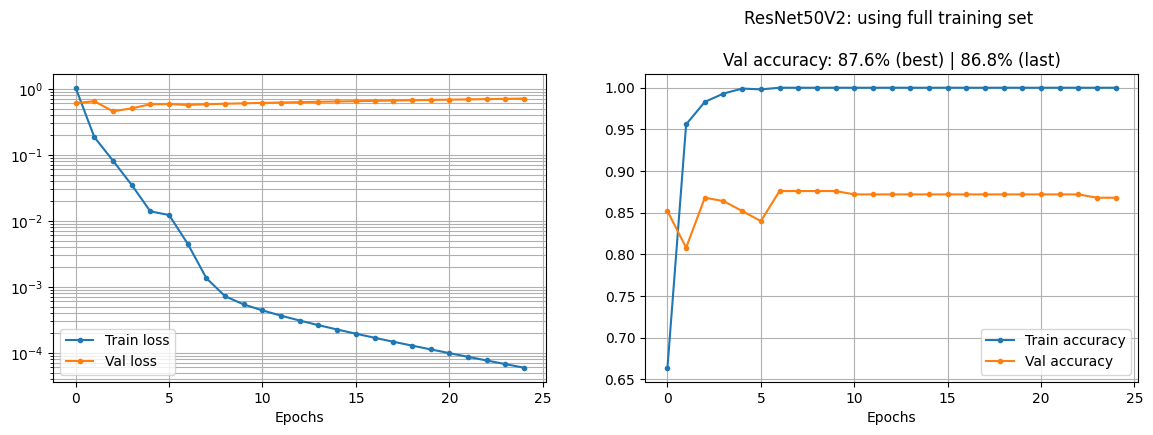

In [18]:
# Retraining the model on the full training data without Data Augmentation

## regenerate to fit the img_size
ds_train = create_dataset(df_train, img_size, batch_size)
ds_test = create_dataset(df_test, img_size, batch_size)


baseline_resnet50V2 = create_resnet50V2_model(input_shape=input_shape, num_classes=10)
baseline_resnet50V2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
    
history = baseline_resnet50V2.fit(ds_train, validation_data=ds_val, epochs=epochs, batch_size=batch_size)

plots(history, net_name='ResNet50V2: using full training set \n')

#### Analyzing the two last graphs, we can tell that increasing the number of data (in this case, images per class) has the effect of decrease the training accuracy (reduce overfitting) while increase the validation accuracy, because the model starts to generalize better. Furthermore, training the model using the whole training dataset showed to increase and stabilize its performance, reaching a validation accuracy above 80%.

### **3 - Results on Test Set**

#### 3.1

In [19]:
# Accuracy on test set

_, accuracy_test = baseline_resnet50V2.evaluate(ds_test)

print(f'Accuracy on test set: {accuracy_test:.6f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8855 - loss: 0.5349
Accuracy on test set: 0.872000


#### 3.2

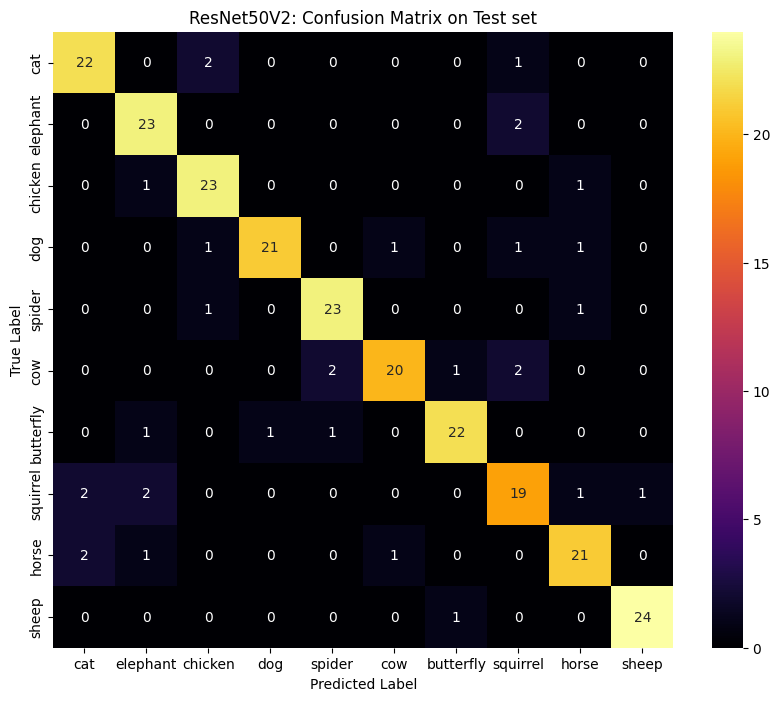

              precision    recall  f1-score   support

         cat       0.85      0.88      0.86        25
    elephant       0.82      0.92      0.87        25
     chicken       0.85      0.92      0.88        25
         dog       0.95      0.84      0.89        25
      spider       0.88      0.92      0.90        25
         cow       0.91      0.80      0.85        25
   butterfly       0.92      0.88      0.90        25
    squirrel       0.76      0.76      0.76        25
       horse       0.84      0.84      0.84        25
       sheep       0.96      0.96      0.96        25

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250



In [20]:
# Confusion matrix plot

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


## to store the predictions of the model
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = baseline_resnet50V2.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

## calculates the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = df_test['class'].unique()

## plotting it
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50V2: Confusion Matrix on Test set')
plt.show()

## Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

#### 3.3

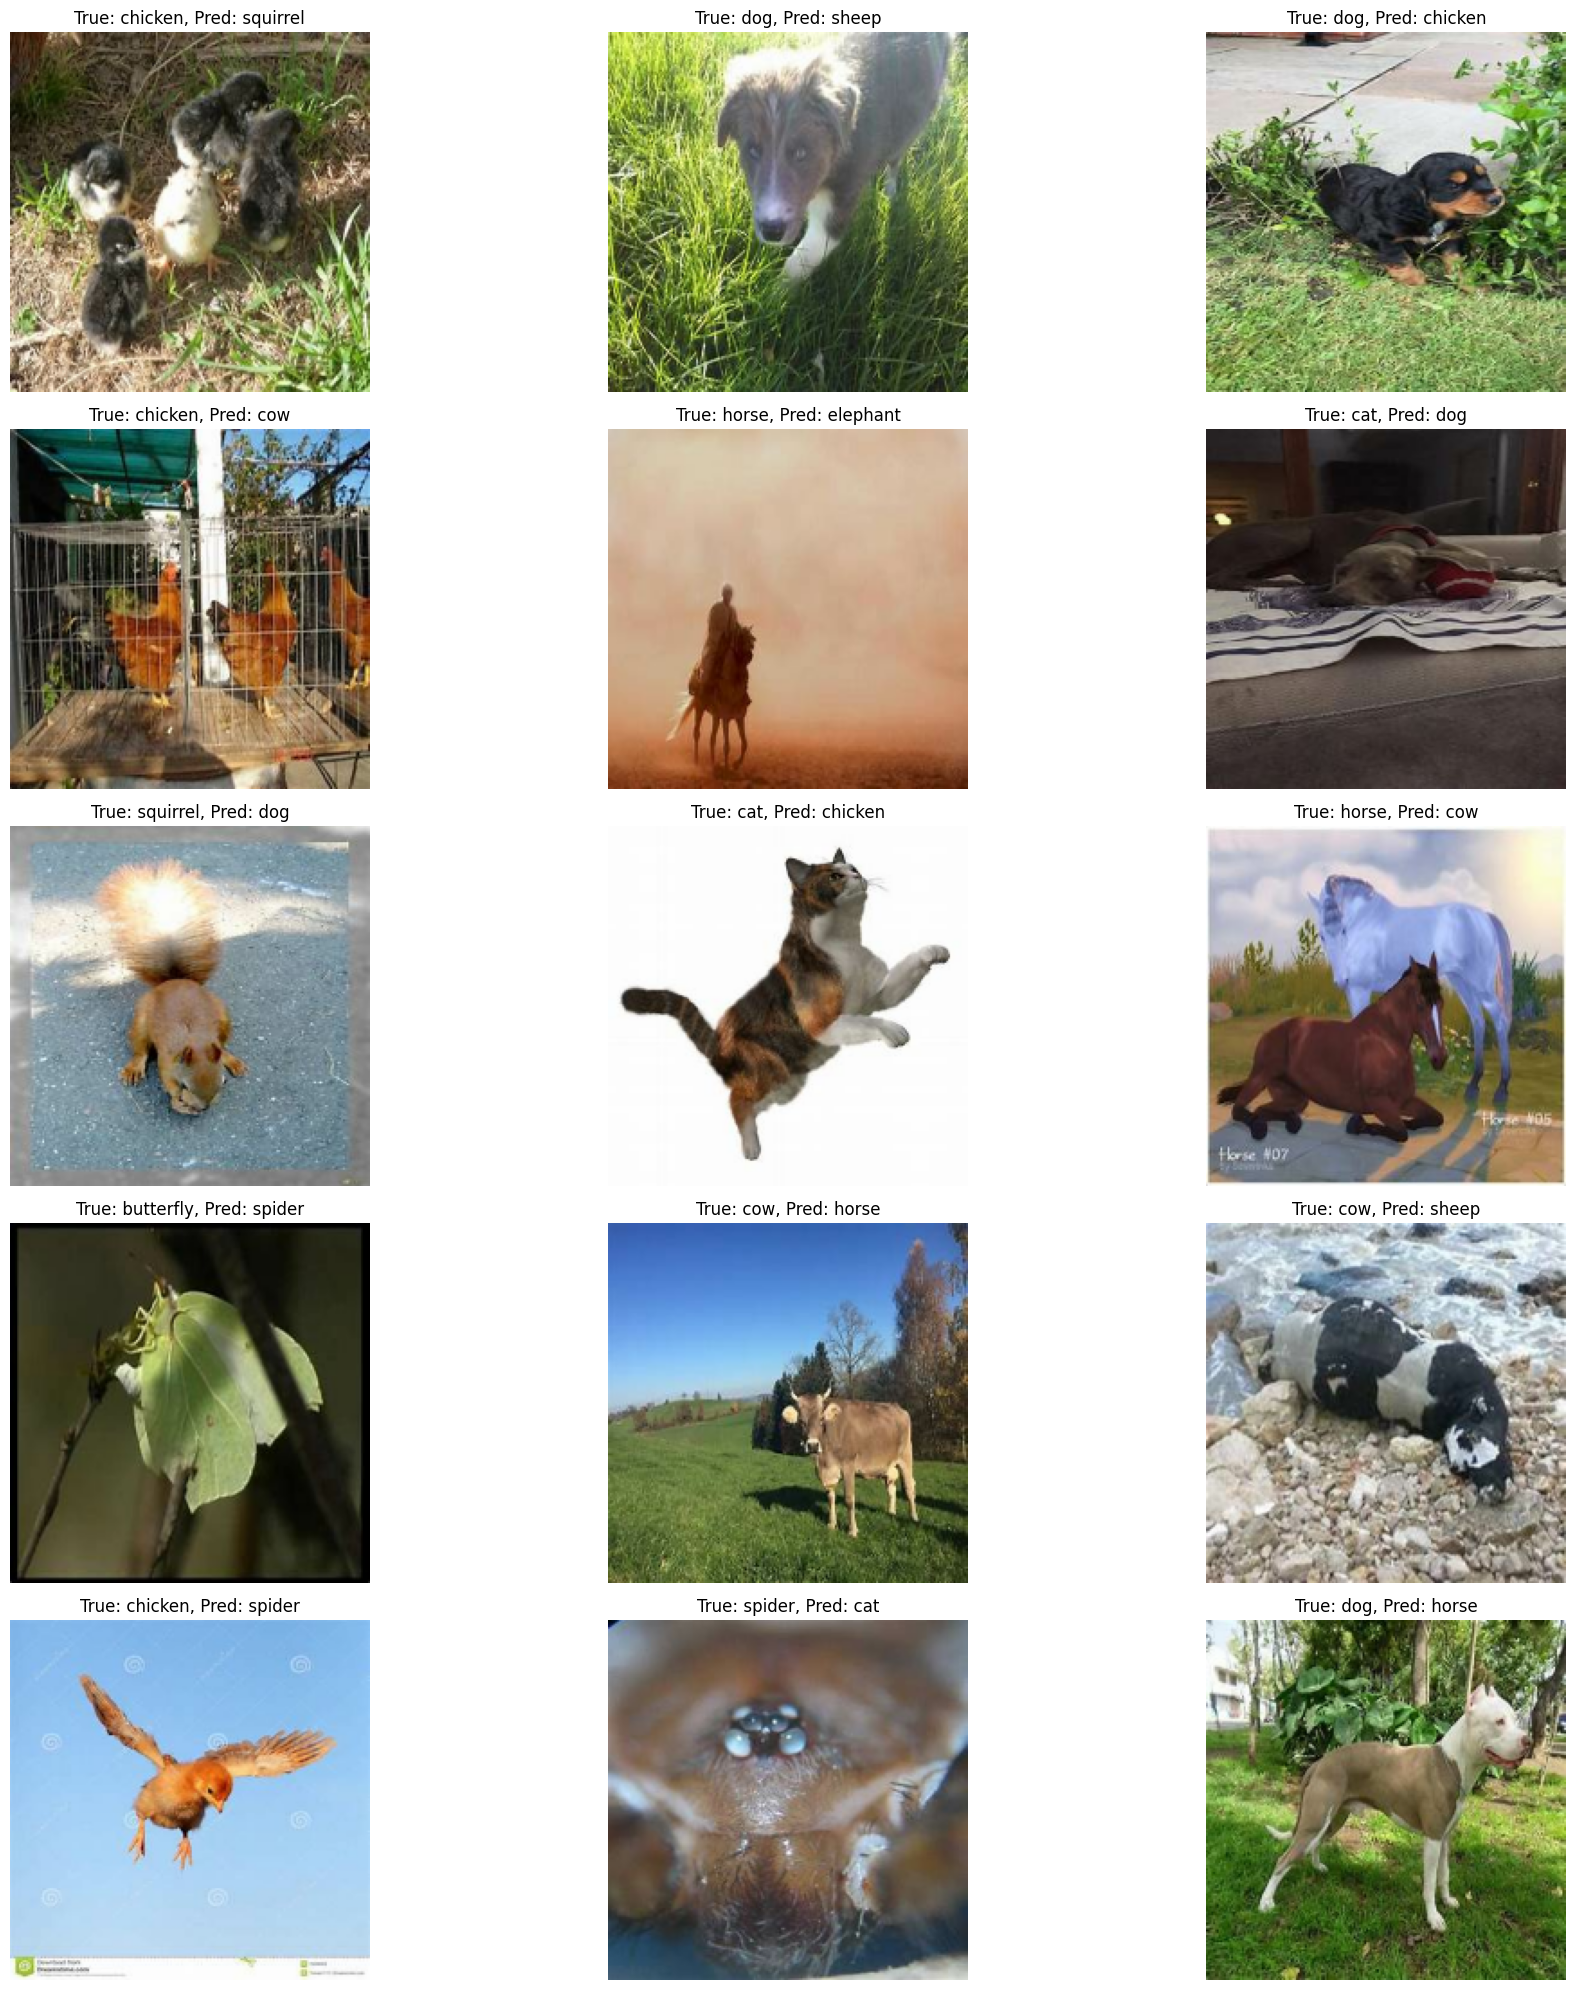

In [21]:
# Showing misclassified images (predictions)


## Identify misclassified data
errors = [(path, true, pred) for path, true, pred in zip(df_test['path'], y_true, y_pred) if true != pred]

## Shows at least 15 images where the model made classification errors
num_errors_to_show = min(15, len(errors))
plt.figure(figsize=(20, 20))

for i in range(num_errors_to_show):
    img_path, true_label, pred_label = errors[i]
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    
    plt.subplot(5, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f'True: {classes[true_label]}, Pred: {classes[pred_label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### The results show that some images are kinda hard for the model to make predictions, because of things such as: illumination, background, and zoom (cropped images), but also shows some easy images that it couldn't predict.

### **4 - Domain Shift**

#### 4.1

In [22]:
# Testing domain shift using CIFAR 10 and CIFAR 100


cifar10_translation = {
    3:"cat",
    5:"dog",
    7:"horse",
    }

# read cifar
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# merge all data
x_cifar_10 = np.concatenate((x_train, x_test), axis=0)
y_cifar_10 = np.concatenate((y_train, y_test))

# map names
cifar10_df = pd.DataFrame(y_cifar_10, columns=['class_int'])
# position of label in CIFAR dataset
cifar10_df["id"] = range(len(cifar10_df))
# select only desired classes
cifar10_df = cifar10_df[cifar10_df["class_int"].isin(cifar10_translation.keys())].copy()

# adds dataset name
cifar10_df["dataset"] = "cifar 10"

# create names
cifar10_df["class"] = cifar10_df["class_int"].map(cifar10_translation)
cifar10_df.value_counts("class")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


class
cat      6000
dog      6000
horse    6000
Name: count, dtype: int64

In [23]:
cifar100_translation = {
  14: "butterfly",
  31: "elephant",
  79: "spider",
  80: "squirrel",
    }

# read cifar
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# merge all data
x_cifar_100 = np.concatenate((x_train, x_test), axis=0)
y_cifar_100 = np.concatenate((y_train, y_test))

# map names
cifar100_df = pd.DataFrame(y_cifar_100, columns=['class_int'])
# position of label in CIFAR dataset
cifar100_df["id"] = range(len(cifar100_df))
# select only desired classes
cifar100_df = cifar100_df[cifar100_df["class_int"].isin(cifar100_translation.keys())].copy()

# adds dataset name
cifar100_df["dataset"] = "cifar 100"

# create names
cifar100_df["class"] = cifar100_df["class_int"].map(cifar100_translation)
display(cifar100_df.value_counts("class"))


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


class
butterfly    600
elephant     600
spider       600
squirrel     600
Name: count, dtype: int64

In [24]:
# concatenate all data again
x_cifar_all = np.concatenate((x_cifar_10, x_cifar_100), axis=0)

# get dfs & configure dfs
cifar_all = pd.concat([cifar10_df, cifar100_df], axis=0)

# fix id for cifar 100
mask_cifar_100 = cifar_all["dataset"] == "cifar 100"
cifar_all.loc[mask_cifar_100, "id"] = len(x_cifar_10) + cifar_all.loc[mask_cifar_100, "id"]

# uses same encoder as the rest of the work
cifar_all['encoded_label'] = cifar_all['class'].map(classes.index)

# reduces instances
cifar_all = reduce_instances_per_class(df=cifar_all, col_name="class", num_instances_per_class=100,)
display(cifar_all.value_counts("class"))


class
butterfly    100
cat          100
dog          100
elephant     100
horse        100
spider       100
squirrel     100
Name: count, dtype: int64

#### 4.2

In [25]:
# Predictions on the out of distribution data

import cv2

# get real labels
label_batch = cifar_all["encoded_label"].values

# get all img information into a numpy array with desired shape
size = img_size
np_imgs = np.zeros(shape=(len(cifar_all), *size, 3), dtype='uint8')
for i, id in enumerate(cifar_all["id"].values):
  img = x_cifar_all[id]
  upscaled_img = cv2.resize(img, dsize=size)

  # saves to numpy
  np_imgs[i, :, :, :] = upscaled_img

# gets model prediction
pred = np.argmax(baseline_resnet50V2.predict(np_imgs), axis=1)
pred

 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

W0000 00:00:1716934002.368242     639 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step


W0000 00:00:1716934010.016350     638 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([9, 3, 4, 7, 9, 7, 9, 2, 7, 7, 9, 7, 7, 2, 8, 7, 7, 3, 7, 9, 9, 7,
       8, 9, 9, 7, 9, 2, 4, 2, 7, 3, 7, 5, 7, 9, 8, 9, 7, 4, 9, 7, 7, 7,
       6, 3, 7, 7, 9, 7, 7, 9, 3, 9, 6, 2, 7, 9, 9, 7, 7, 9, 2, 7, 9, 9,
       3, 8, 0, 7, 3, 2, 9, 7, 7, 7, 5, 7, 9, 7, 3, 8, 4, 3, 9, 7, 9, 7,
       7, 7, 7, 7, 9, 9, 7, 7, 7, 7, 7, 9, 7, 2, 3, 8, 3, 7, 7, 3, 2, 7,
       7, 3, 7, 8, 7, 4, 6, 8, 7, 3, 7, 3, 3, 3, 3, 8, 3, 8, 7, 3, 3, 9,
       7, 3, 8, 2, 3, 9, 7, 3, 3, 7, 3, 3, 7, 3, 3, 7, 3, 2, 4, 8, 3, 7,
       3, 7, 2, 3, 7, 7, 7, 3, 7, 7, 8, 3, 4, 7, 4, 3, 3, 7, 3, 3, 3, 3,
       7, 8, 3, 4, 7, 8, 3, 3, 7, 2, 3, 3, 3, 3, 8, 8, 3, 3, 3, 7, 7, 8,
       3, 3, 7, 8, 8, 2, 8, 8, 7, 9, 8, 1, 8, 3, 7, 7, 8, 8, 8, 7, 7, 7,
       8, 8, 3, 8, 8, 8, 8, 3, 8, 4, 8, 3, 8, 8, 3, 8, 2, 8, 3, 8, 8, 8,
       7, 7, 7, 8, 7, 8, 8, 8, 7, 3, 3, 7, 3, 8, 8, 8, 7, 8, 8, 3, 8, 8,
       8, 7, 8, 8, 8, 8, 8, 2, 8, 8, 6, 7, 8, 8, 3, 8, 8, 8, 7, 8, 8, 7,
       8, 2, 2, 7, 3, 7, 3, 8, 8, 8, 8, 8, 8, 8, 4,

#### 4.3

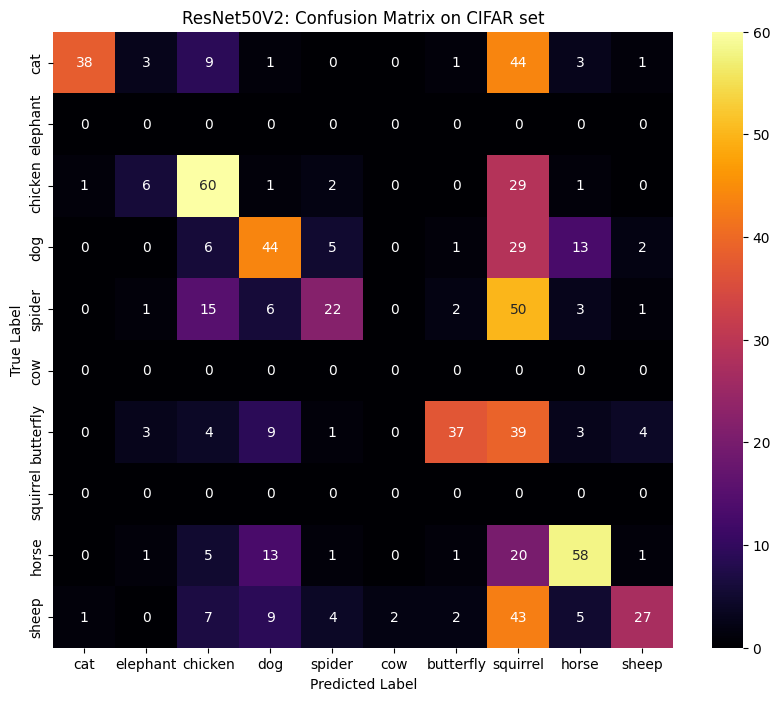

              precision    recall  f1-score   support

         cat       0.95      0.38      0.54       100
    elephant       0.00      0.00      0.00         0
     chicken       0.57      0.60      0.58       100
         dog       0.53      0.44      0.48       100
      spider       0.63      0.22      0.33       100
         cow       0.00      0.00      0.00         0
   butterfly       0.84      0.37      0.51       100
    squirrel       0.00      0.00      0.00         0
       horse       0.67      0.58      0.62       100
       sheep       0.75      0.27      0.40       100

    accuracy                           0.41       700
   macro avg       0.49      0.29      0.35       700
weighted avg       0.71      0.41      0.50       700



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Repeting the section 3 analysis

y_true = label_batch
y_pred = pred

## calculates the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = df_test['class'].unique()

## plotting it
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50V2: Confusion Matrix on CIFAR set')
plt.show()

## Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

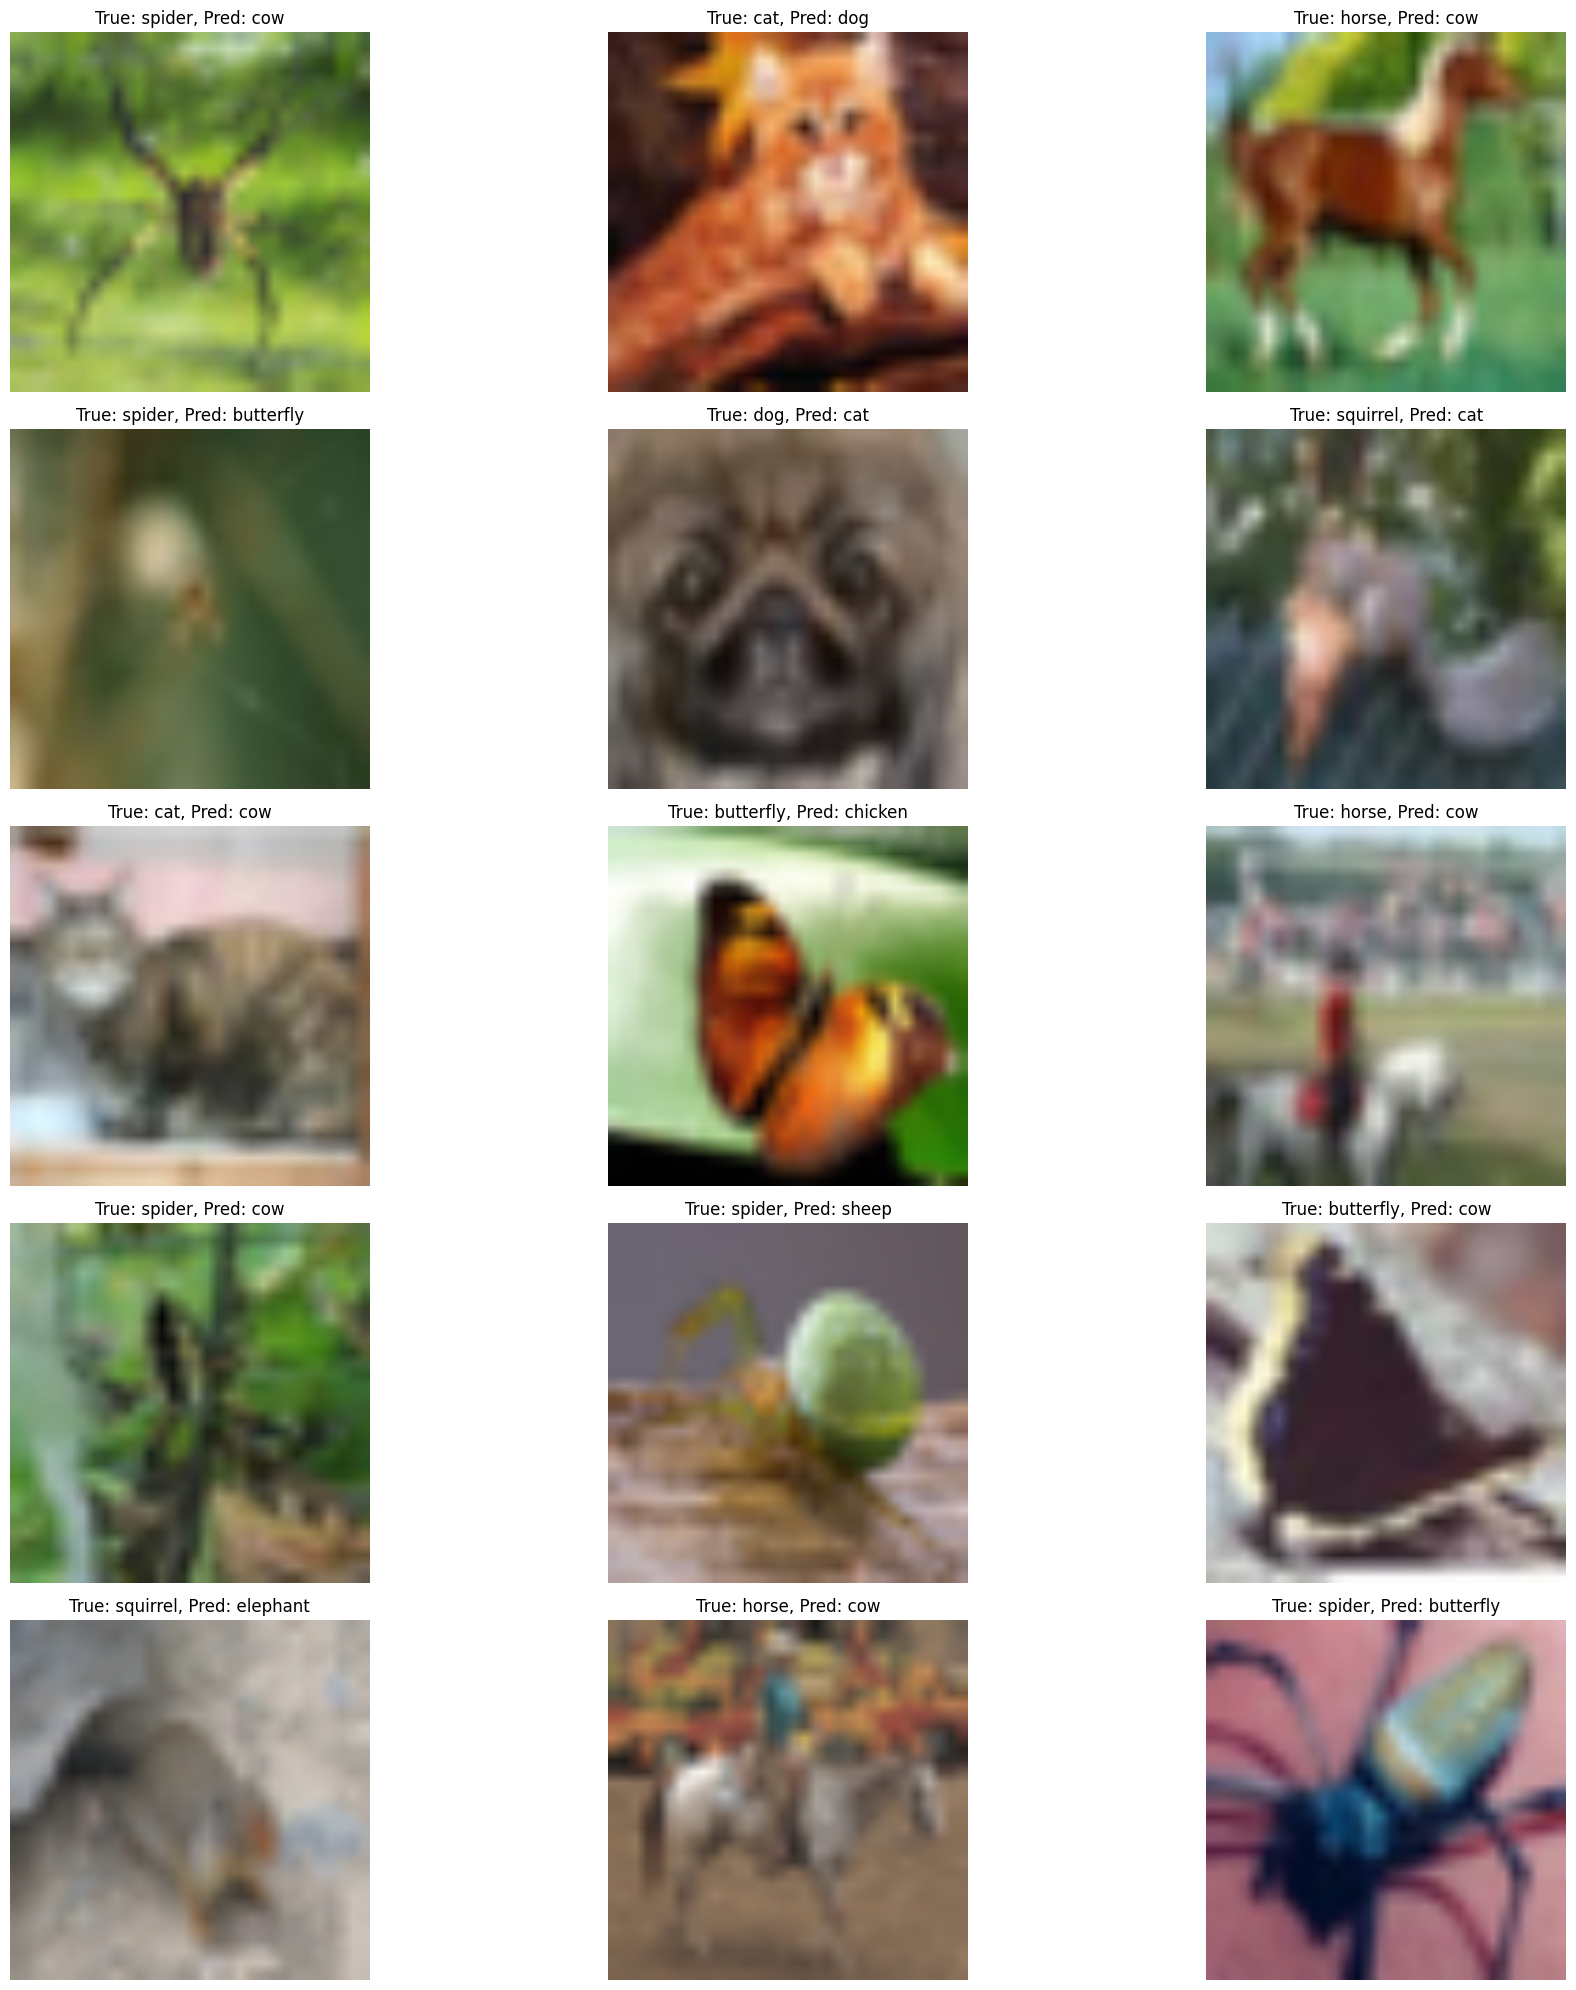

In [27]:
# Showing misclassified images (predictions)


## Identify misclassified data
errors = [(img, true, pred) for img, true, pred in zip(np_imgs, y_true, y_pred) if true != pred]

## Shuffle the errors
random.shuffle(errors)

## Shows at least 15 images where the model made classification errors
num_errors_to_show = min(15, len(errors))
plt.figure(figsize=(20, 20))

for i in range(num_errors_to_show):
    img, true_label, pred_label = errors[i]
    plt.subplot(5, 3, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f'True: {classes[true_label]}, Pred: {classes[pred_label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Analysing the misclassified samples we can notice that the resolution of the images are low, meaning that they are smaller than the model's input and, hence, less "clear". The other analysis that can be made is that the data of CIFAR is at least slightly different from the trained distribution, which also hurts the model's performance.

### **5 - Comments and Discussion**

#### Choosing a model's architecture and also fine-tuning it can be a very challenging and time-consuming task, where you need to optimize at least a few hyperparameters to obtain a satisfactory result on the task that you're applying. There are a ton of tests that you may need to realize and if you're not monitoring the model's response, you can easily get it wrong. Furthermore, you often face some trade-offs, where you have to decide over a better performance or time efficiency, for instance, and this can set a boundary on your final result.

